In [1]:
import os
import numpy as np
from itertools import cycle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tensorboardX import SummaryWriter

from utils import weights_init
from utils import transform_config
from data_loader import MNIST_Paired
from networks import Encoder, Decoder
from torch.utils.data import DataLoader
from utils import imshow_grid, mse_loss, reparameterize, l1_loss

In [2]:
import argparse
parser = argparse.ArgumentParser()

# add arguments
parser.add_argument('--cuda', type=bool, default=True, help="run the following code on a GPU")

parser.add_argument('--batch_size', type=int, default=64, help="batch size for training")
parser.add_argument('--image_size', type=int, default=28, help="height and width of the image")
parser.add_argument('--num_channels', type=int, default=1, help="number of channels in the images")
parser.add_argument('--initial_learning_rate', type=float, default=0.0001, help="starting learning rate")

parser.add_argument('--style_dim', type=int, default=16, help="dimension of style latent space")
parser.add_argument('--class_dim', type=int, default=16, help="dimension of class latent space")
parser.add_argument('--num_classes', type=int, default=10, help="number of classes on which the data set trained")

# loss function coefficient
# 3 reconstruction coef for 64 dim space
parser.add_argument('--reconstruction_coef', type=float, default=2., help="coefficient for reconstruction term")
parser.add_argument('--reverse_cycle_coef', type=float, default=10., help="coefficient for reverse cycle loss term")
parser.add_argument('--kl_divergence_coef', type=float, default=3., help="coefficient for KL-Divergence loss term")

parser.add_argument('--beta_1', type=float, default=0.9, help="default beta_1 val for adam")
parser.add_argument('--beta_2', type=float, default=0.999, help="default beta_2 val for adam")


# paths to save models
parser.add_argument('--encoder_save', type=str, default='encoder', help="model save for encoder")
parser.add_argument('--decoder_save', type=str, default='decoder', help="model save for decoder")

parser.add_argument('--log_file', type=str, default='log.txt', help="text file to save training logs")

parser.add_argument('--load_saved', type=bool, default=False, help="flag to indicate if a saved model will be loaded")
parser.add_argument('--start_epoch', type=int, default=0, help="flag to set the starting epoch for training")
parser.add_argument('--end_epoch', type=int, default=100, help="flag to indicate the final epoch of training")

FLAGS = parser.parse_known_args()[0]

In [3]:
encoder = Encoder(style_dim=FLAGS.style_dim, class_dim=FLAGS.class_dim)
encoder.apply(weights_init)

decoder = Decoder(style_dim=FLAGS.style_dim, class_dim=FLAGS.class_dim)
decoder.apply(weights_init)

# load saved models
encoder.load_state_dict(torch.load(os.path.join('checkpoints', FLAGS.encoder_save), map_location=torch.device('cpu')))
decoder.load_state_dict(torch.load(os.path.join('checkpoints', FLAGS.decoder_save), map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
X_1 = torch.FloatTensor(FLAGS.batch_size, FLAGS.num_channels, FLAGS.image_size, FLAGS.image_size)
X_2 = torch.FloatTensor(FLAGS.batch_size, FLAGS.num_channels, FLAGS.image_size, FLAGS.image_size)

paired_mnist = MNIST_Paired(root='mnist', download=True, train=True, transform=transform_config)
loader = cycle(DataLoader(paired_mnist, batch_size=FLAGS.batch_size, shuffle=True, num_workers=0, drop_last=True))

image_batch_1, image_batch_2, _ = next(loader)

# shuffle batch1
image_batch_1 = image_batch_1[torch.randperm(FLAGS.batch_size)]

0it [00:00, ?it/s]

9920512it [00:06, 1477871.23it/s]                             


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


0it [00:00, ?it/s]

32768it [00:01, 28063.42it/s]                           
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


1654784it [00:05, 326719.95it/s]                             
0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw


8192it [00:01, 6486.92it/s]             


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...
Done!


In [5]:
X_1.copy_(image_batch_1)
X_2.copy_(image_batch_2)

style_mu_1, style_logvar_1, class_1 = encoder(Variable(X_1))
style_1 = reparameterize(training=False, mu=style_mu_1, logvar=style_logvar_1)

_, __, class_2 = encoder(Variable(X_2))

reconstructed_X_1 = decoder(style_1, class_1)
reconstructed_X_2 = decoder(style_1, class_2)

In [6]:
def get_image_list(batch):
    return [batch[i, 0, :, :].detach().numpy() for i in range(batch.shape[0])]

re_x1_im = get_image_list(reconstructed_X_1)
re_x2_im = get_image_list(reconstructed_X_2)
x1_im = get_image_list(X_1)
x2_im = get_image_list(X_2)

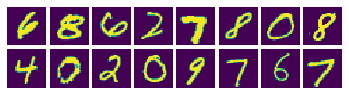

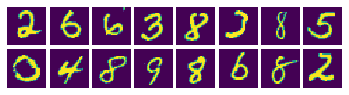

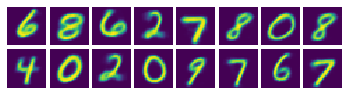

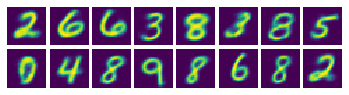

In [8]:
imshow_grid(x1_im)
imshow_grid(x2_im)
imshow_grid(re_x1_im)
imshow_grid(re_x2_im)